## Putting it all together

### Full Modeling and Validation Process

- Split into training and test sets
- Use the training set to select candidate models and nuisance parameters
    - repeated averaged cross-validation
- Use the test set to compare candidate models and selct final model
    - repeated averaged cross-validation

In [72]:
import numpy as np
import pylab as plt
import pandas as pd
import sympy as sp
sp.init_printing()
%matplotlib inline

In [9]:
# sklearn imports
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

In [7]:
data = pd.read_csv('pima_diabetes.csv')
print(data.head(10))

X = data.drop('class', axis=1)

y = data['class']

   num_pregnancies  ogtt  blood_pressure  skin_fold  2hour_serum   BMI  \
0                6   148              72         35            0  33.6   
1                1    85              66         29            0  26.6   
2                8   183              64          0            0  23.3   
3                1    89              66         23           94  28.1   
4                0   137              40         35          168  43.1   
5                5   116              74          0            0  25.6   
6                3    78              50         32           88  31.0   
7               10   115               0          0            0  35.3   
8                2   197              70         45          543  30.5   
9                8   125              96          0            0   0.0   

   pedigree  age  class  
0     0.627   50      1  
1     0.351   31      0  
2     0.672   32      1  
3     0.167   21      0  
4     2.288   33      1  
5     0.201   30      0  
6  

0     1
1     0
2     1
3     0
4     1
5     0
6     1
7     0
8     1
9     1
10    0
11    1
12    0
13    1
14    1
...
753    1
754    1
755    1
756    0
757    1
758    0
759    1
760    0
761    1
762    0
763    0
764    0
765    0
766    1
767    0
Name: class, Length: 768, dtype: int64

### 1) The training and test sets

In [8]:


X_train, X_test, y_train, y_test = cross_validation.train_test_split(
               X, y, test_size=0.4, random_state=1555)

### A function to print the results of a grid search

In [50]:
def print_grid_results(fitted_grid):
    print("The best score ({0}) was {1}".format(fitted_grid.scoring, fitted_grid.best_score_))
    for key, val in fitted_grid.best_params_.items():
        print("The best value of the parameter {0} is {1}.".format(key, val))

### Logistic regression

We have the parameter C to select

In [41]:
from sklearn.linear_model import LogisticRegression


params = {'C' : np.logspace(0,4,5)}


logistic_grid = GridSearchCV(LogisticRegression(), cv=5, param_grid=params,scoring='accuracy')

logistic_grid.fit(X_train, y_train)


print_grid_results(logistic_grid)

best_logistic_model = LogisticRegression(**logistic_grid.best_params_)
best_logistic_model

The best score (accuracy) was 0.7717391304347826
The best value of the parameter C is 10.0.


LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

### kNN

In [63]:
from sklearn import neighbors

wts = ['uniform', 'distance']
ks = np.arange(1,50,1,dtype='int')
ps = np.arange(1,5,1,dtype='int')

# These names must match the parameter names - see help(neighbors.KNeighborsClassifier)"
knn_params = {"weights": wts, "n_neighbors": ks, 'p': ps}

knn_grid = GridSearchCV(neighbors.KNeighborsClassifier(), cv = 5, param_grid=knn_params, scoring='accuracy')

knn_grid.fit(X_train, y_train)

print_grid_results(knn_grid)

best_knn_model = neighbors.KNeighborsClassifier(**knn_grid.best_params_)
best_knn_model

The best score (accuracy) was 0.75
The best value of the parameter weights is distance.
The best value of the parameter n_neighbors is 25.
The best value of the parameter p is 1.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=25, p=1, weights='distance')

### A function for training and testing for cv

In [66]:
def train_test_cv(model, X, y, train, test):
    model.fit(X[train], y[train])
    return model.score(X[test], y[test])
    

## 2) Compare models using the test set

In [ ]:
from sklearn.lda import LDA
from sklearn.qda import QDA


N_trials = 10

models = [best_knn_model, best_logistic_model, LDA(), QDA()]
model_names = ['knn', 'logistic', 'LDA', 'QDA']

model_results = {name : np.zeros(N_trials) for name in model_names}

for i in range(N_trials):
    kfolds = cross_validation.KFold(len(y_test), n_folds=5, shuffle=True, random_state=7)
    for train, test in kfolds:
        for name, model in zip(model_names, models):
            score = train_test_cv(model, X_test, y_test, train, test)
            model_results[name][i] = score
            

In [71]:
from scipy.stats import sem

for model, results in model_results.items():
    mean = np.mean(results)
    SE = sem(results)
    print("The model {0} had an average accuracy of {1:.3} (SE of {2:.3}).".format(model, mean, SE))

The model QDA had an average accuracy of 0.738 (SE of 3.7e-17).
The model logistic had an average accuracy of 0.802 (SE of 0.00164).
The model LDA had an average accuracy of 0.82 (SE of 3.7e-17).
The model knn had an average accuracy of 0.738 (SE of 3.7e-17).


## ROC curves

<img src="http://scikit-learn.org/stable/_images/plot_roc_crossval_001.png" width:"500">

How to make an ROC curve

1. line the data up by the descriminant function
    1. positive for one class, negative for another
2. start at most positive value
3. for each true positive, move up
4. for each false positive, move right

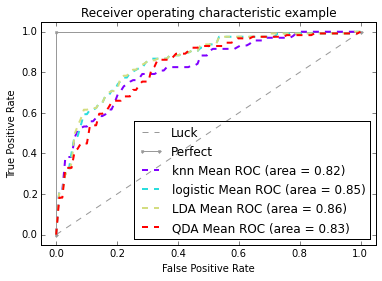

In [80]:
from scipy import interp

from sklearn.metrics import roc_curve, auc

mean_tpr = {name: 0.0 for name in model_names}
mean_fpr = {name:np.linspace(0, 1, 100) for name in model_names}
colors = plt.cm.rainbow(np.linspace(0,1,len(models)))

for train, test in kfolds:
    for name, model in zip(model_names, models):
        probas_ = model.fit(X_test[train], y_test[train]).predict_proba(X_test[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_test[test], probas_[:, 1])
        mean_tpr[name] += interp(mean_fpr[name], fpr, tpr)
        mean_tpr[name][0] = 0.0


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.plot([0, 0, 1], [0, 1, 1], '.-', color=(0.6, 0.6, 0.6), label='Perfect')


for name, color in zip(model_names, colors):
    mean_tpr[name] /= len(kfolds)
    mean_tpr[name][-1] = 1.0
    mean_auc = auc(mean_fpr[name], mean_tpr[name])
    plt.plot(mean_fpr[name], mean_tpr[name], 'k--',
         label='{0} Mean ROC (area = {1:.2})'.format(name, mean_auc), lw=2, c=color)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()